In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anjaliraj123","key":"c145853128781d464ee04fe68817a0f0"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm competition_test/*

rm: cannot remove 'competition_test/*': No such file or directory


In [ ]:
!rm sample_data/*
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andyczhao/covidx-cxr2
from zipfile import ZipFile
file_name=("/content/covidx-cxr2.zip")
with ZipFile(file_name,'r') as zip:
             zip.extractall()
             print("done")

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion() 
from __future__ import print_function
import torch.nn as nn
from torch.nn.utils.weight_norm import weight_norm
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets,models
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import os
import pandas as pd
from google.colab.patches import cv2_imshow
from skimage import io
from torchvision.io import read_image
import torchvision
import numpy as np
import time
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
from PIL import Image, ImageOps             

100% 11.6G/11.6G [04:07<00:00, 50.1MB/s]
100% 11.6G/11.6G [04:07<00:00, 50.3MB/s]
done


In [ ]:
from sklearn.utils import resample

In [ ]:
transform_train = transforms.Compose([transforms.Resize((224,224)),transforms.RandomApply([
        torchvision.transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip()],0.7),
		transforms.ToTensor()])

In [ ]:
class CovidDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None,train=None):

        self.landmarks_frame = pd.read_csv(csv_file, sep=" ", header=None)
        self.landmarks_frame.columns= ["Sl.no","File_Name","Status","Source"]
        self.landmarks_frame.drop(["Sl.no","Source"], axis=1, inplace=True)

        self.landmarks_frame.loc[self.landmarks_frame['Status'] =='positive', 'Status'] = 1
        self.landmarks_frame.loc[self.landmarks_frame['Status'] =='negative', 'Status'] = 0 
        

        if train:
           self.landmarks_frame['num'] = np.where(self.landmarks_frame['Status']== 1, 6,1)
           self.landmarks_frame =self.landmarks_frame.loc[self.landmarks_frame.index.repeat(self.landmarks_frame['num'])].reset_index(drop=True)
           self.landmarks_frame.drop(['num'], axis=1, inplace=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image=Image.open(img_name)
        image=ImageOps.grayscale(image)
        landmarks = self.landmarks_frame.iloc[idx, -1]

        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
    

        return sample

In [ ]:
train_dataset = CovidDataset(csv_file='/content/train.txt',
                                           root_dir='/content/train',
                                           transform=transform_train,train=True)
test_dataset = CovidDataset(csv_file='/content/test.txt',
                                           root_dir='/content/test',
                                           transform=transform_train)
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
train_dataloader = DataLoader(train_dataset, batch_size=64,
                 shuffle=True, num_workers=0)

test_dataloader = DataLoader(test_dataset, batch_size=64,
                shuffle=True, num_workers=0)

In [ ]:
def show_landmarks(image, landmarks):
    plt.imshow(np.asarray(image).transpose((1,2,0)))
    plt.pause(0.001)

In [ ]:
class MyResNet(nn.Module):

    def __init__(self, in_channels=1):
        super(MyResNet, self).__init__()
        self.Network = torchvision.models.resnet50(pretrained=True)

        # original definition of the first layer on the renset class
         #self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        

        self.Network.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        for param in self.Network.parameters():
          param.requires_grad = False
        self.Network.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.BatchNorm1d(512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.Sigmoid())  
       

    def forward(self, x):
        return self.Network(x)


In [ ]:
model = MyResNet().float()

batch_size=64
from torch import optim
'''for param in model.Network.parameters():
    param.requires_grad = False


model.Network.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.BatchNorm1d(512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.Sigmoid())
print(list(model.model.fc.parameters())[0].grad)  '''



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)  
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.Network.fc.parameters(), lr=0.000010024, momentum=0.9)

cuda:0


In [ ]:
optimizer = optim.SGD(model.Network.fc.parameters(), lr=0.000010024, momentum=0.9)

In [ ]:
optimizer.state_dict

<bound method Optimizer.state_dict of SGD (
Parameter Group 0
    dampening: 0
    lr: 1.0024e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)>

In [ ]:
eye = torch.eye(2).to(device)
classes=[0,1]

In [ ]:
chckpnt=torch.load("/content/drive/MyDrive/19_oct_9.pth")
model.load_state_dict(chckpnt['model_state_dict'])
optimizer.load_state_dict(chckpnt['optimizer_state_dict'])

In [ ]:
batch_size=64

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag =y_pred

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    return correct_results_sum

In [ ]:
optimizer = optim.SGD(model.Network.fc.parameters(), lr=0.001, momentum=0.9,weight_decay=0.01)


In [ ]:
epochs = 9
steps = 0
running_loss = 0

print_every = 40
train_losses, test_losses = [], []
train_losses_epoch, test_losses_epoch = [], []
test_accuracy,train_accuracy=[],[]
test_accuracy_epoch,train_accuracy_epoch=[],[]
model.train()
for epoch in range(0,1):
    correct=0.0
    running_loss_epoch = 0
    for i, data in enumerate(train_dataloader,0):
       
        #inputs, labels = data['image'], data['landmarks']
       # print(list(model.model.fc.parameters())[0].grad)  
        inputs, labels = data['image'].to(device), data['landmarks'].to(device) 
        labels = eye[labels]  
        optimizer.zero_grad()
       # print(inputs.shape)
        logps = model.forward(inputs.float())
        loss = criterion(logps,torch.max(labels, 1)[1])
        _, predicted = torch.max(logps, 1)
        _, labels = torch.max(labels, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #running_loss_epoch += loss.item()      
        correct+=binary_acc(predicted,labels)   
        print(correct/(batch_size*(i+1)))   
    test_loss = 0
    accuracy = 0
    ##running_loss=0.0
    model.eval()

    
    with torch.no_grad():
            
        for i, data in enumerate(test_dataloader,0):
                    #inputs, labels = data['image'], data['landmarks']
            inputs, labels = data['image'].to(device), data['landmarks'].to(device)  
            labels = eye[labels]     
            logps = model.forward(inputs.float())
            batch_loss =  criterion(logps,torch.max(labels, 1)[1])
            _, predicted = torch.max(logps, 1)
            _, labels = torch.max(labels, 1)
            test_loss += batch_loss.item()
             
            accuracy+=binary_acc(predicted,labels) 
                    
            print(accuracy/(batch_size*(i+1)))
        train_losses.append(running_loss/len(train_dataloader))
        test_losses.append(test_loss/len(test_dataloader))  
        train_accuracy.append(100*correct/(26700))
        test_accuracy.append(100*accuracy/400)                          
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train accuracy: {100*correct/(26700):.5f}.."
              f"Train loss: {running_loss/len(train_dataloader):.5f}.. "
              f"Test loss: {test_loss/(len(test_dataloader)):.5f}.. "
              f"Test accuracy: {100*accuracy/400:.5f}")
        running_loss = 0.0
        correct=0.0
        model.train()
torch.save(model, 'aerialmodel.pth')

tensor(0.9375, device='cuda:0')
tensor(0.9453, device='cuda:0')
tensor(0.9167, device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(0.9313, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9258, device='cuda:0')
tensor(0.9236, device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(0.9233, device='cuda:0')
tensor(0.9258, device='cuda:0')
tensor(0.9267, device='cuda:0')
tensor(0.9286, device='cuda:0')
tensor(0.9271, device='cuda:0')
tensor(0.9229, device='cuda:0')
tensor(0.9228, device='cuda:0')
tensor(0.9210, device='cuda:0')
tensor(0.9194, device='cuda:0')
tensor(0.9195, device='cuda:0')
tensor(0.9196, device='cuda:0')
tensor(0.9190, device='cuda:0')
tensor(0.9212, device='cuda:0')
tensor(0.9212, device='cuda:0')
tensor(0.9194, device='cuda:0')
tensor(0.9183, device='cuda:0')
tensor(0.9178, device='cuda:0')
tensor(0.9196, device='cuda:0')
tensor(0.9208, device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(0

In [ ]:
Train accuracy: 92.55805..Train loss: 0.39193.. Test loss: 0.42169.. Test accuracy: 88.25000
Train accuracy: 92.90263..Train loss: 0.38921.. Test loss: 0.41418.. Test accuracy: 89.25000

In [ ]:
epochs = 9
steps = 0
running_loss = 0

print_every = 40
train_losses, test_losses = [], []
train_losses_epoch, test_losses_epoch = [], []
test_accuracy,train_accuracy=[],[]
test_accuracy_epoch,train_accuracy_epoch=[],[]
model.train()
for epoch in range(0,2):
    correct=0.0
    running_loss_epoch = 0
    for i, data in enumerate(train_dataloader,0):
       
        #inputs, labels = data['image'], data['landmarks']
       # print(list(model.model.fc.parameters())[0].grad)  
        inputs, labels = data['image'].to(device), data['landmarks'].to(device) 
        labels = eye[labels]  
        optimizer.zero_grad()
       # print(inputs.shape)
        logps = model.forward(inputs.float())
        loss = criterion(logps,torch.max(labels, 1)[1])
        _, predicted = torch.max(logps, 1)
        _, labels = torch.max(labels, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #running_loss_epoch += loss.item()      
        correct+=binary_acc(predicted,labels)   
        print(correct/(batch_size*(i+1)))   
    test_loss = 0
    accuracy = 0
   # running_loss=0.0
    model.eval()

    
    with torch.no_grad():
            
        for i, data in enumerate(test_dataloader,0):
                    #inputs, labels = data['image'], data['landmarks']
            inputs, labels = data['image'].to(device), data['landmarks'].to(device)  
            labels = eye[labels]     
            logps = model.forward(inputs.float())
            batch_loss =  criterion(logps,torch.max(labels, 1)[1])
            _, predicted = torch.max(logps, 1)
            _, labels = torch.max(labels, 1)
            test_loss += batch_loss.item()
             
            accuracy+=binary_acc(predicted,labels) 
                    
            print(accuracy/(batch_size*(i+1)))
        train_losses.append(running_loss/len(train_dataloader))
        test_losses.append(test_loss/len(test_dataloader))  
        train_accuracy.append(100*correct/(26700))
        test_accuracy.append(100*accuracy/400)                          
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train accuracy: {100*correct/(26700):.5f}.."
              f"Train loss: {running_loss/len(train_dataloader):.5f}.. "
              f"Test loss: {test_loss/(len(test_dataloader)):.5f}.. "
              f"Test accuracy: {100*accuracy/400:.5f}")
        running_loss = 0.0
        correct=0.0
        model.train()
torch.save(model, 'aerialmodel.pth')

tensor(0.7031, device='cuda:0')
tensor(0.7188, device='cuda:0')
tensor(0.7188, device='cuda:0')
tensor(0.7344, device='cuda:0')
tensor(0.7344, device='cuda:0')
tensor(0.7214, device='cuda:0')
tensor(0.7210, device='cuda:0')
tensor(0.7324, device='cuda:0')
tensor(0.7431, device='cuda:0')
tensor(0.7516, device='cuda:0')
tensor(0.7557, device='cuda:0')
tensor(0.7513, device='cuda:0')
tensor(0.7536, device='cuda:0')
tensor(0.7522, device='cuda:0')
tensor(0.7521, device='cuda:0')
tensor(0.7578, device='cuda:0')
tensor(0.7638, device='cuda:0')
tensor(0.7639, device='cuda:0')
tensor(0.7632, device='cuda:0')
tensor(0.7656, device='cuda:0')
tensor(0.7671, device='cuda:0')
tensor(0.7692, device='cuda:0')
tensor(0.7663, device='cuda:0')
tensor(0.7689, device='cuda:0')
tensor(0.7694, device='cuda:0')
tensor(0.7686, device='cuda:0')
tensor(0.7726, device='cuda:0')
tensor(0.7729, device='cuda:0')
tensor(0.7742, device='cuda:0')
tensor(0.7729, device='cuda:0')
tensor(0.7712, device='cuda:0')
tensor(0

KeyboardInterrupt: ignored

In [ ]:
epochs = 9
steps = 0
running_loss = 0

print_every = 40
train_losses, test_losses = [], []
train_losses_epoch, test_losses_epoch = [], []
test_accuracy,train_accuracy=[],[]
test_accuracy_epoch,train_accuracy_epoch=[],[]
model.train()
for epoch in range(0,1):
    correct=0.0
    running_loss_epoch = 0
    for i, data in enumerate(train_dataloader,0):

        inputs, labels = data['image'].to(device), data['landmarks'].to(device) 
        labels = eye[labels]  
        #optimizer.zero_grad()
       # print(inputs.shape)
        logps = model.forward(inputs.float())
        loss = criterion(logps,torch.max(labels, 1)[1])
        _, predicted = torch.max(logps, 1)
        _, labels = torch.max(labels, 1)
        #loss.backward()
        #optimizer.step()
        running_loss += loss.item()
        #running_loss_epoch += loss.item()      
        correct+=binary_acc(predicted,labels)   
        print(correct/(batch_size*(i+1)))   
    test_loss = 0
    accuracy = 0
   # running_loss=0.0
    '''model.eval()

    
    with torch.no_grad():
            
        for i, data in enumerate(test_dataloader,0):
                    #inputs, labels = data['image'], data['landmarks']
            inputs, labels = data['image'].to(device), data['landmarks'].to(device)  
            labels = eye[labels]     
            logps = model.forward(inputs.float())
            batch_loss =  criterion(logps,torch.max(labels, 1)[1])
            _, predicted = torch.max(logps, 1)
            _, labels = torch.max(labels, 1)
            test_loss += batch_loss.item()
             
            accuracy+=binary_acc(predicted,labels) 
                    
            print(accuracy/(batch_size*(i+1)))
        train_losses.append(running_loss/len(train_dataloader))
        test_losses.append(test_loss/len(test_dataloader))  
        train_accuracy.append(100*correct/(26700))
        test_accuracy.append(100*accuracy/400)                          
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train accuracy: {100*correct/(26700):.5f}.."
              f"Train loss: {running_loss/len(train_dataloader):.5f}.. "
              f"Test loss: {test_loss/(len(test_dataloader)):.5f}.. "
              f"Test accuracy: {100*accuracy/400:.5f}")
        running_loss = 0.0
        correct=0.0
        model.train()'''
torch.save(model, 'aerialmodel.pth')


tensor(0.5156, device='cuda:0')
tensor(0.4766, device='cuda:0')
tensor(0.5365, device='cuda:0')
tensor(0.5195, device='cuda:0')
tensor(0.5125, device='cuda:0')


KeyboardInterrupt: ignored

In [ ]:
optimizer = optim.SGD(model.model.fc.parameters(), lr=0.0001, momentum=0.9)

In [ ]:


torch.save({
            'epoch': 7,
            'model_state_dict': model.state_dict(),
          #  'model_fc_paramteres':model.model.fc.parameters(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_loss': train_losses,
            'test_loss':test_losses,
            'test_accuracy':list(test_accuracy),
            'train_accuracy':list(train_accuracy)
            }, '19_oct_18_sgd.pth')

In [ ]:


test_accuracy=[68.00,65.25,73.000,73.500,70.2500,75.500,67.2500,74.750,75.750,86.00,77.25,62.25,65.00,78.25,83.75,87.25,81.5,78.00,77.5,84.00,77.25,80.5,73.0,79.5,87.75]

train_accuracy=[90.62500,91.71875,89.84375,92.50000,87.81250,90.31250,93.12500,91.25000,92.50000,89.68750,91.87500,91.87500,91.87500,92.50000,92.18750,91.40625,92.18750,91.87500,91.25000,93.59375,92.34375,91.40625,92.18750,92.34375,81.87500]
print(len(test_accuracy),len(train_accuracy))

25 25


In [ ]:
!cp 19_oct_18_sgd.pth /content/drive/MyDrive

In [ ]:
train_accuracy=[78.80946,
83.30516,
84.17049,
84.8708,
84.99155,
85.37793,
86.58939,
86.63367,
87.59156,
87.72036,
87.57144,
88.23553,
88.59373,
88.48507,
89.16928,
89.45102,
89.8213,
90.08291,
89.84142,
90.65443,
90.32037,
91.09313]
test_accuracy=[82.5,
82.75,
84.25,
81.25,
85.5,
82,
83.25,
84.75,
85.25,
86.25,
87.25,
88.75,
84.75,
85.5,
88.25,
86.75,
85.75,
89,
90.75,
89.25,
88.5,
90.5]

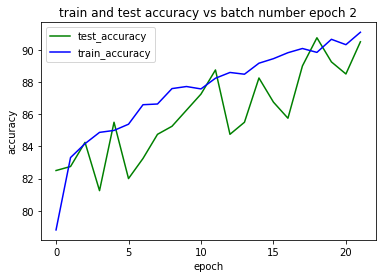

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(22),test_accuracy, color='g', label='test_accuracy')
plt.plot(np.arange(22),train_accuracy, color='b', label='train_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('train and test accuracy vs batch number epoch 2')
plt.legend()
plt.savefig('acc_transfer_learning_22epochs.png')


In [ ]:
plt.plot(np.arange(25),test_losses, color='r', label='test_loss')
plt.plot(np.arange(25),train_losses, color='g', label='train_loss')
plt.xlabel('batch_number')
plt.ylabel('loss')
plt.title('train and test loss vs batch number epoch 2')
plt.legend()
plt.savefig('loss_transfer_learning_epoch2.png')


NameError: ignored

In [ ]:
plt.plot(np.arange(25),train_losses)
plt.xlabel('batch_number')
plt.ylabel('train_loss')
plt.savefig('train_loss_transfer_learning.png')

In [ ]:
test=[62.23,87.75,68.75000,79.25,81.25000]
train=[90,81.87500,92.03125,85.31250,83.59375]

In [ ]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
   # print((np.squeeze(image)),(np.squeeze(image)).shape)
    plt.imshow((np.squeeze(image)))
    
    plt.pause(0.001)

In [ ]:
transformed_dataset = {
    x:  CovidDataset(csv_file='/content/'+x +'.txt',
                                           root_dir='/content/train',
                                           transform=data_transforms  )
    for x in [TRAIN, TEST]
}

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])
# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)    

In [ ]:
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)


NameError: ignored

In [ ]:
dataloader = DataLoader(transformed_dataset[x], batch_size=8,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    print(sample_batched['image'].shape)
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    

    grid = utils.make_grid(images_batch)
   # print(grid)
    plt.imshow(grid.numpy().transpose((1, 2,0)))

    '''for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')'''

a=enumerate(dataloader)
print()

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'])

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

NameError: ignored

In [ ]:
print(transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
    RandomAffine(degrees=[-40.0, 40.0], scale=(1, 2), shear=[-15.0, 15.0])
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


In [ ]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
   # print((np.squeeze(image)),(np.squeeze(image)).shape)
    plt.imshow((np.squeeze(image)))
    
    plt.pause(0.001)

In [ ]:
transform =   transforms.Compose([
                                  transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        #print(h,w)
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
       # landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        #print(h-new_h)

        top = torch.randint(0, h - new_h,(1,))
        left = torch.randint(0, w - new_w,(1,))

        image = image[top: top + new_h,
                      left: left + new_w]

                      

       # landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        
        image= sample['image']
        landmarks =sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        #torch.from_numpy(landmarks)
        image = image.transpose((2,0, 1))
       # print(type(landmarks))
        a = {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
      #  print(type(a))        
        return a

 train_dataset = CovidDataset(csv_file='/content/train.txt',
                                           root_dir='/content/train',
                                           transform=transforms.Compose([
                                                                         
                                               Rescale(228),
                                                RandomCrop(224),
                                              
                                               ToTensor(),
                                               
                                               
                                           ]))
test_dataset = CovidDataset(csv_file='/content/test.txt',
                                           root_dir='/content/test',
                                           transform=transforms.Compose([
                                                                         
                                               Rescale(228),
                                               RandomCrop(224),
                                               
                                               ToTensor(),
                                               
                                               
                                           ]))
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True, num_workers=0)       

In [ ]:
num_ftrs = model_ft.classifier[0].out_features
import torch.optim as optim
from torch.optim import lr_scheduler 
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
#model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in trainloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
